In [159]:
# Prep training data
from copyreg import pickle
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import sys
from tkinter import Y
import gzip
import itertools
import numpy as np
import pandas as pd
import pickle as pk
import torch
import gpytorch
import plotly.express as px
sys.path.append('..')
sys.path.insert(0, '../src')

In [160]:
from model import GridGP
from acq_funcs import EI, PI, cust_acq, thompson
from plotter import vis_pred, vis_acq

### Data Read and Pre-processing

In [161]:
# read data and display
def read_dat(dir="/Users/valenetjong/Bayesian-Optimization-Ferroelectrics/data/",
            src_file = "Bolometer_readings_PulseForge.xlsx", sheet= "Combined"):
    file = dir + src_file
    fe_data = pd.read_excel(file, sheet_name=sheet, usecols=['Energy density new cone (J/cm^2)',
                            'Time (ms)','2 Qsw/(U+|D|) 1e6cycles'])
    fe_data.dropna(subset=['2 Qsw/(U+|D|) 1e6cycles'], inplace=True)
    fe_data = fe_data[fe_data['2 Qsw/(U+|D|) 1e6cycles']!= 0]
    return fe_data

def display_data(fe_data):
    """
    [display_data(fe_data)] creates a cross-section scatter plot of all combinations
    of the four input parameters and single output parameter.
    """
    # plot each cross-section
    fig = px.scatter_matrix(fe_data, dimensions=['Energy density new cone (J/cm^2)', 
    "Time (ms)", "2 Qsw/(U+|D|) 1e6cycles"])
    fig.update_layout(margin=dict(r=20, l=10, b=10, t=10))
    fig.update_layout(height=1000)
    fig.show()

In [162]:
fe_data = read_dat()
print(fe_data)

    Time (ms)  Energy density new cone (J/cm^2)  2 Qsw/(U+|D|) 1e6cycles
4         0.5                              2.73                 0.873026
5         0.5                              3.40                 2.677245
6         1.0                              3.79                 1.699015
7         1.0                              6.44                 3.805053
8         1.5                              5.36                 3.334856
9         1.5                              8.99                 4.535153
11        5.0                              8.80                 1.362510
13        5.0                             14.67                 3.841291
19        0.5                              5.24                 1.201357
22        5.0                             14.89                 3.513652
23        2.0                             10.13                 3.470871
24        0.5                              4.51                 0.263298
25        0.5                              5.37    

In [163]:
display_data(fe_data)

### Grid/Parameter Space

In [164]:
import emukit
import GPy
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs.random_design import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign

In [165]:
time_len_min, time_len_max, time_len_step = [fe_data["Time (ms)"].min(), fe_data["Time (ms)"].max(), 0.1]  ## Unit: ms
time_len_var = np.arange(time_len_min, time_len_max+time_len_step*0.1, time_len_step)
time_len_num = len(time_len_var)

e_den_min, e_den_max, e_den_step = [fe_data["Energy density new cone (J/cm^2)"].min(), fe_data["Energy density new cone (J/cm^2)"].max(), 0.01]  # Unit: J/cm^2
### Give step a scaling factor of 0.1 to avoid numercial errors such as 1.7000002
e_den_var = np.arange(e_den_min, e_den_max+e_den_step*0.1, e_den_step)
e_den_num = len(e_den_var)

var_array = [time_len_var, e_den_var]
x_labels =  ["Time (ms)", "Energy density new cone (J/cm^2)"]

def x_normalizer(X, var_array = var_array):
    
    def max_min_scaler(x, x_max, x_min):
        return (x-x_min)/(x_max-x_min)
    x_norm = []
    for x in (X):
           x_norm.append([max_min_scaler(x[i], 
                         max(var_array[i]), 
                         min(var_array[i])) for i in range(len(x))])
            
    return np.array(x_norm)

def x_denormalizer(x_norm, var_array = var_array):
    
    def max_min_rescaler(x, x_max, x_min):
        return x*(x_max-x_min)+x_min
    x_original = []
    for x in (x_norm):
           x_original.append([max_min_rescaler(x[i], 
                              max(var_array[i]), 
                              min(var_array[i])) for i in range(len(x))])

    return np.array(x_original)


def get_closest_array(suggested_x):

    def get_closest_value(given_value, array_list):
        absolute_difference_function = lambda list_value : abs(list_value - given_value)
        closest_value = min(array_list, key=absolute_difference_function)
        return closest_value
    
    var_list = var_array
    modified_array = []
    for x in suggested_x:
        modified_array.append([get_closest_value(x[i], var_list[i]) for i in range(len(x))])
    return np.array(modified_array)

In [166]:
parameter_space = ParameterSpace([ContinuousParameter("Time (ms)", 0-1/(time_len_num-1)/2, 1+1/(time_len_num-1)/2),
                                  ContinuousParameter("Energy density new cone (J/cm^2)", 0-1/(e_den_num-1)/2, 1+1/(e_den_num-1)/2),
                                 ])

### Initialize GP Model

In [167]:
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper

x_exp = x_normalizer(fe_data.iloc[:, 0:2].values)
y_exp = np.transpose([fe_data.iloc[:,-1].values])
X, Y = [x_exp, y_exp]

input_dim = len(X[0])
ker = GPy.kern.Matern52(input_dim = input_dim, ARD =True)#
ker.lengthscale.constrain_bounded(1e-2, 1)
ker.variance.constrain_bounded(1e-2, 1000.0)
model_gpy = GPRegression(X , -Y, ker)#Emukit is a minimization tool; need to make Y negative
model_gpy.Gaussian_noise.variance = 0.35**2
model_gpy.Gaussian_noise.variance.fix()
model_gpy.randomize()
model_gpy.optimize_restarts(num_restarts=20,verbose =False, messages=False)
objective_model = GPyModelWrapper(model_gpy)
print(objective_model.model.kern.lengthscale)
print(objective_model.model.kern.variance)

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


  index  |  GP_regression.Mat52.lengthscale  |  constraints  |  priors
  [0]    |                       0.99999993  |   0.01,1.0    |        
  [1]    |                       0.02365010  |   0.01,1.0    |        
  index  |  GP_regression.Mat52.variance  |  constraints  |  priors
  [0]    |                    6.86880303  |  0.01,1000.0  |        


MAE: 0.06   RMSE: 0.07   spearman: 0.994   R² score: 0.997


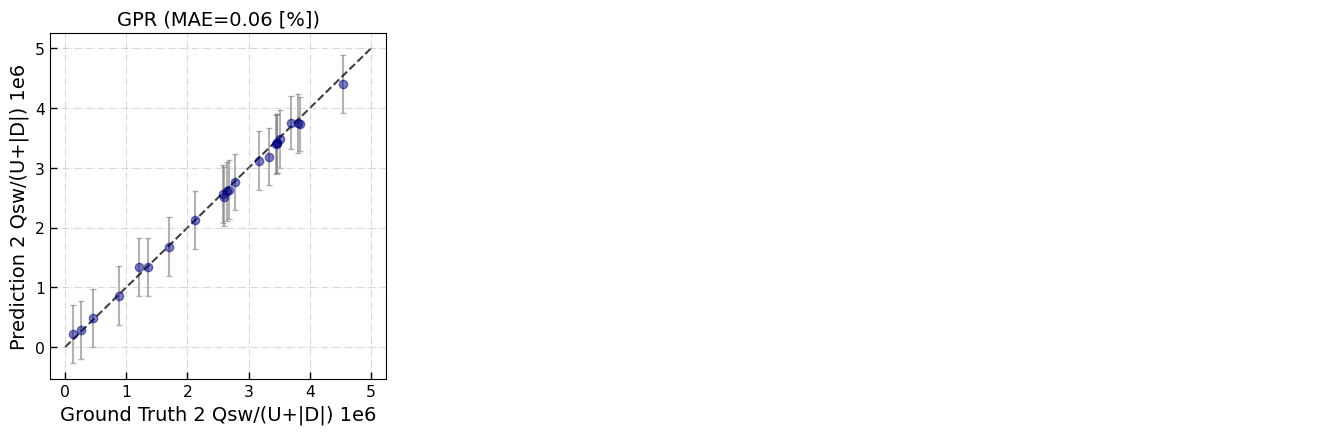

In [168]:
# get GP predictions
f_obj =  objective_model.model.predict
y_pred, y_uncer = f_obj(X)
y_pred = -y_pred[:,-1]  # get back non-neg outputs and get array out of embedding
y_uncer = np.sqrt(y_uncer[:,-1])

from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from scipy.stats import spearmanr
import matplotlib.pyplot as plt 

# plot predictions against experimental data
fig, axes = plt.subplots(1, 3, figsize=(5.5*3, 4.5))
fs = 14
lims1 = (0, 5)
axes[0].scatter(Y[:,-1], y_pred, alpha = 0.5, c = 'navy' , edgecolor = 'navy')
axes[0].errorbar(Y[:,-1], y_pred, yerr = y_uncer, ms = 0, 
                 ls = '', capsize = 2, alpha = 0.6,
                 color = 'gray', zorder = 0)
axes[0].plot(lims1, lims1, 'k--', alpha=0.75, zorder=0)
rmse_value = np.sqrt(mean_squared_error(Y[:,-1], y_pred))
mae_value = mean_absolute_error(Y[:,-1], y_pred)
spearman_value = spearmanr(Y[:,-1], y_pred)[0]
rsquared_value = r2_score(Y[:,-1], y_pred)

print('MAE:',np.round(mae_value,2), ' ',
      'RMSE:', np.round(rmse_value,2), ' ',
      'spearman:', np.round(spearman_value,3), ' ',
      'R² score:', np.round(rsquared_value,3))

title = 'GPR' + " (MAE=%.2f" % mae_value+' [%])'
axes[0].set_xlabel('Ground Truth 2 Qsw/(U+|D|) 1e6', fontsize = fs)
axes[0].set_ylabel('Prediction 2 Qsw/(U+|D|) 1e6', fontsize = fs)
axes[0].set_title(title, fontsize = fs)
        
for i in range(len(axes)):
    axes[i].tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
    axes[i].grid(True, linestyle='-.')
plt.subplots_adjust(wspace = 0.4)

axes[1].axis("off")
axes[2].axis("off")

plt.show()

### GP Training and Eval

In [169]:
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, \
                                                      NegativeLowerConfidenceBound, \
                                                      MaxValueEntropySearch, \
                                                      ProbabilityOfImprovement
from emukit.core.acquisition import IntegratedHyperParameterAcquisition

np.random.seed(10)#to make sure the random results is reproducible 
bs = 8
acquisition = NegativeLowerConfidenceBound(objective_model, beta = 1)

# Make loop and collect points
bayesopt= BayesianOptimizationLoop(model=objective_model, 
                                   space=parameter_space, 
                                   acquisition=acquisition,
                                   batch_size = bs)
                                  
print('total condition no.:', len(X))
print('total device no.:', len(bayesopt.loop_state.Y))
print('maximum Y (2 Qsw/(U+|D|) 1e6cycles): ', -np.min(np.transpose(np.round(bayesopt.loop_state.Y, 2))))

X_new = bayesopt.candidate_point_calculator.compute_next_points(bayesopt.loop_state)
f_acq = bayesopt.candidate_point_calculator.acquisition.evaluate

df = fe_data
df_Xnew = pd.DataFrame(get_closest_array(x_denormalizer(X_new)), columns = x_labels)
df_all = pd.concat([df.iloc[:,0:2], df_Xnew])
df_all_ = df_all.drop_duplicates()
df_Xnew = df_all_.iloc[len(df):len(df)+bs]
df_Xnew = df_Xnew.sort_values(by=list(df.columns[0:2]), ignore_index = True)
df_Xnew.index = np.arange(len(df_Xnew))+len(df)
print('New X:',len(df_Xnew))
df_Xnew

total condition no.: 23
total device no.: 23
maximum Y (2 Qsw/(U+|D|) 1e6cycles):  4.54
New X: 2


,Time (ms),Energy density new cone (J/cm^2)
23,2.8,9.05
24,2.9,9.05


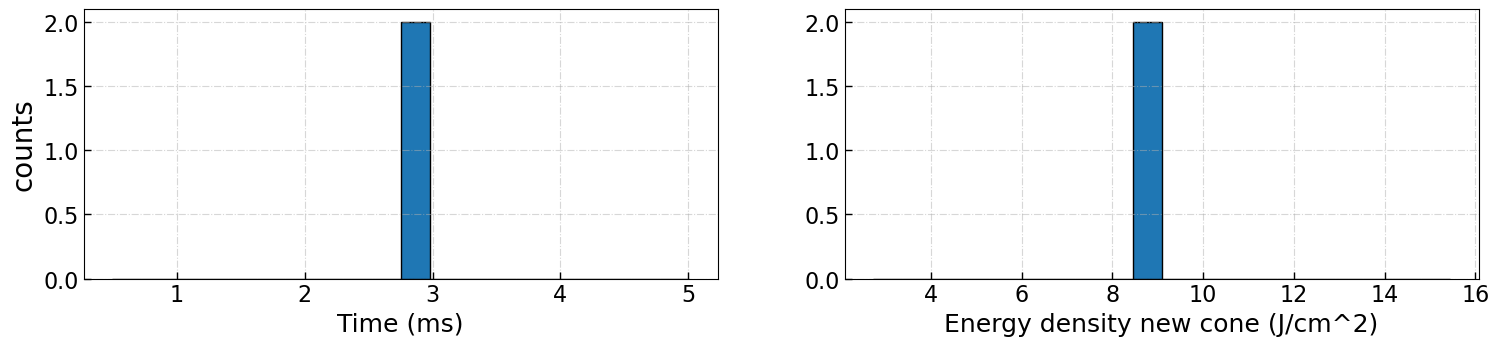

In [170]:
df_x = df_Xnew
df_cols = df.columns
n_col = 2 # num of columns per row in the figure
fs = 20
for n in np.arange(0, 2, n_col):
    fig,axes = plt.subplots(1, n_col, figsize=(18, 3.5), sharey = False)
    fs = 20
    for i in np.arange(n_col):
        if n< len(df_cols):
            axes[i].hist(df_x.iloc[:,n], bins= 20, range = (min(var_array[n])- 0.05*abs(var_array[n][1]-var_array[n][0]),
                                                            max(var_array[n])+0.05*abs(var_array[n][1]-var_array[n][0])), 
                         edgecolor='black') ####
            axes[i].set_xlabel(df_cols[n], fontsize = 18)
        else:
            axes[i].axis("off")
        n = n+1      
    axes[0].set_ylabel('counts', fontsize = fs)
    for i in range(len(axes)):
        axes[i].tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
        axes[i].grid(True, linestyle='-.')
    plt.show()

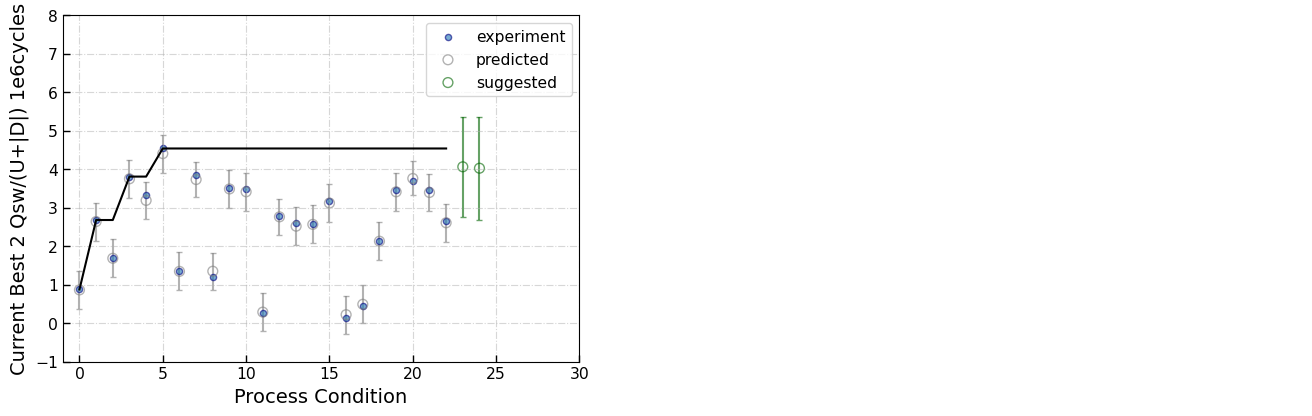

In [171]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4.5), sharey = False)
fs = 14
exp_cond = np.transpose(range(len(Y)))
exp_eff = np.transpose(Y[:,0])

# plot experimental points
axes[0].scatter(exp_cond, exp_eff, #facecolor = 'none',
            edgecolor = 'navy', s = 20, alpha = 0.6, label = 'experiment')

# connect max experimental points with black line
axes[0].plot(np.transpose(exp_cond), np.maximum.accumulate(np.transpose(exp_eff)), 
         marker = 'o', ms = 0, c = 'black')

# plot training predictions
axes[0].scatter(np.arange(len(y_pred)), y_pred,
                s = 50, facecolors='none', alpha = 0.6, edgecolor = 'gray', label = 'predicted')

# plot error bars
axes[0].errorbar(np.arange(len(y_pred)), y_pred, yerr = y_uncer,  
                 ms = 0, ls = '', capsize = 2, alpha = 0.6, 
                 color = 'gray', zorder = 0)

# calculate suggested point
y_pred_new, y_uncer_new = f_obj(x_normalizer(df_Xnew.values))
y_pred_new = -y_pred_new[:,-1]
y_uncer_new = np.sqrt(y_uncer_new[:,-1])

# plot suggested point
axes[0].scatter(np.arange(len(df_Xnew))+len(X), y_pred_new,
                s = 50, facecolors='none', alpha = 0.6, edgecolor = 'darkgreen', label = 'suggested')
axes[0].errorbar(np.arange(len(df_Xnew))+len(X), y_pred_new, yerr = y_uncer_new,  
                 ms = 0, ls = '', capsize = 2, alpha = 0.6, 
                 color = 'darkgreen', zorder = 0)

# set up axes and labels
axes[0].set_ylabel('Current Best 2 Qsw/(U+|D|) 1e6cycles', fontsize = fs)
axes[0].set_xlabel('Process Condition', fontsize = fs)
axes[0].set_ylim(-1, 8)
axes[0].set_xlim(-1, 30)
axes[0].set_xticks(np.arange(0,35,5))
axes[0].legend(fontsize = fs*0.8)

axes[1].axis("off")
for ax in axes:
    ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
    ax.grid(True, linestyle='-.')
plt.subplots_adjust(wspace = 0.4)

plt.show()

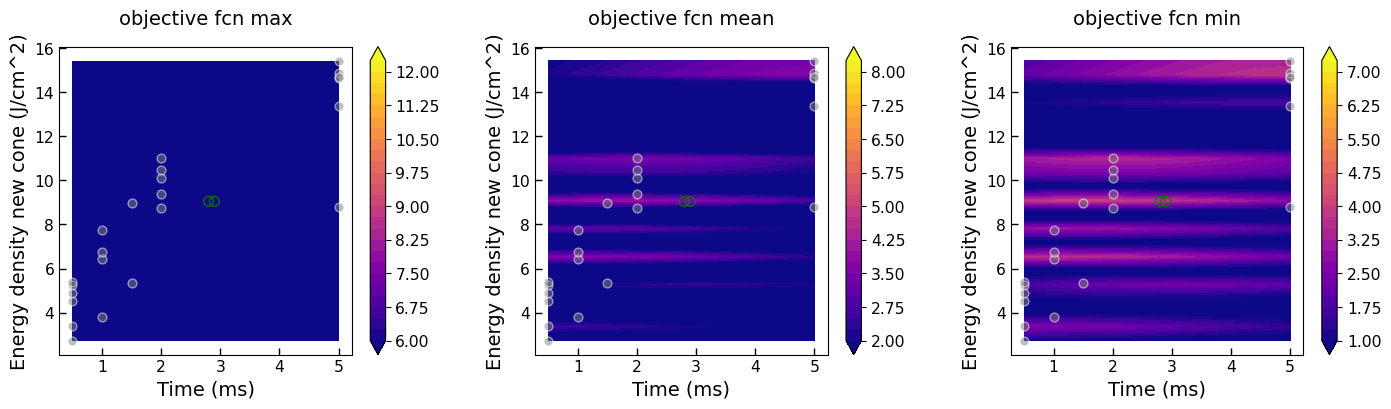

In [172]:
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_columns = df.iloc[:,0:2].columns
for i in range(input_dim):
    for j in range(input_dim-i-1):
        
## Generate a 2D grid for Contour plot
        ind1 = i
        ind2 = j+i+1
        n_steps =21
        x1x2y_pred, x1x2y_uncer =[[],[]]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:,ind1] = x1
                x_temp[:,ind2] = x2
                y_pred, y_uncer = f_obj(x_temp)
                y_pred = -y_pred
                x1_org = x_denormalizer(x_temp)[0,ind1]
                x2_org = x_denormalizer(x_temp)[0,ind2]
                x1x2y_pred.append([x1_org, x2_org, np.max(y_pred), np.mean(y_pred), np.min(y_pred)])
                x1x2y_uncer.append([x1_org, x2_org, np.max(np.sqrt(y_uncer)), np.mean(np.sqrt(y_uncer)), np.min(np.sqrt(y_uncer))])
                
        x1 = np.array(x1x2y_pred, dtype=object)[:,0].reshape(n_steps, n_steps)
        x2 = np.array(x1x2y_pred, dtype=object)[:,1].reshape(n_steps, n_steps)
        y_pred_max = np.array(x1x2y_pred, dtype=object)[:,2].reshape(n_steps, n_steps)
        y_pred_mean = np.array(x1x2y_pred, dtype=object)[:,3].reshape(n_steps, n_steps)
        y_pred_min = np.array(x1x2y_pred, dtype=object)[:,4].reshape(n_steps, n_steps)
        
        y_uncer_max = np.array(x1x2y_uncer, dtype=object)[:,2].reshape(n_steps, n_steps)
        y_uncer_mean = np.array(x1x2y_uncer, dtype=object)[:,3].reshape(n_steps, n_steps)
        y_uncer_min = np.array(x1x2y_uncer, dtype=object)[:,4].reshape(n_steps, n_steps)

        fs = 14
        title_pad = 16
        
## Contour for Prediction Efficiency Mean
        fig,axes = plt.subplots(1, 3, figsize=(17, 4), sharey = False, sharex = False)
        colorbar_offset = [6, 2, 1]
        for ax, c_offset, y in zip(axes, colorbar_offset,
                                   [y_pred_max, y_pred_mean, y_pred_min]):#[y_pred_max, y_pred_mean, y_pred_min]
            
            c_plt1 = ax.contourf(x1, x2, y, levels = np.arange(26)*0.25+c_offset, cmap='plasma', extend = 'both')
            cbar = fig.colorbar(c_plt1, ax= ax)
            cbar.ax.tick_params(labelsize=fs*0.8)
            ax.scatter(x_denormalizer(X)[:, ind1], 
                       x_denormalizer(X)[:, ind2], 
                       s = 40, facecolors='gray', alpha = 0.5, edgecolor = 'white')

            ax.scatter(df_Xnew.values[:, ind1], 
                       df_Xnew.values[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'green')
            ax.set_xlabel(str(x_columns[ind1]),fontsize =  fs)
            ax.set_ylabel(str(x_columns[ind2]),fontsize =  fs)

            x1_delta = (np.max(x1)-np.min(x1))*0.05
            x2_delta = (np.max(x2)-np.min(x2))*0.05
            ax.set_xlim(np.min(x1)-x1_delta, np.max(x1)+x1_delta)
            ax.set_ylim(np.min(x2)-x2_delta, np.max(x2)+x2_delta)
            ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8)#, grid_alpha = 0.5

        axes[0].set_title('objective fcn max', pad = title_pad,fontsize =  fs)
        axes[1].set_title('objective fcn mean', pad = title_pad,fontsize =  fs)
        axes[2].set_title('objective fcn min', pad = title_pad,fontsize =  fs)
        plt.subplots_adjust(wspace = 0.3)
        plt.show()


### Save Predictions and Visualize 

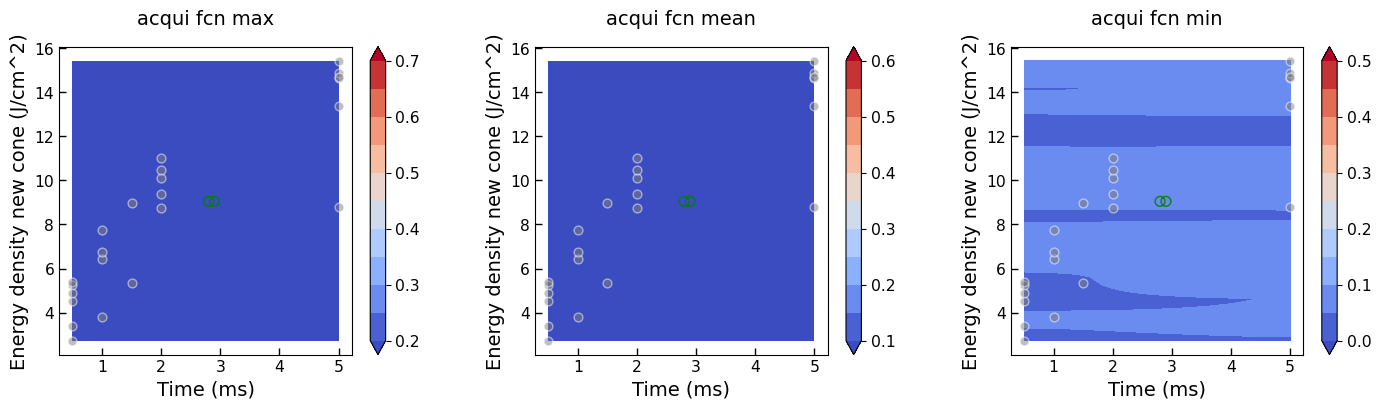

In [173]:
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_columns = df.iloc[:,0:2].columns
for i in range(input_dim):
    for j in range(input_dim-i-1):
        ind1 = i
        ind2 = j+i+1
        n_steps =21
        x1x2y_pred, x1x2y_var =[[],[]]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:,ind1] = x1
                x_temp[:,ind2] = x2
                yc_pr = f_acq(x_temp)
                x1_org = x_denormalizer(x_temp)[0,ind1]
                x2_org = x_denormalizer(x_temp)[0,ind2]
                x1x2y_pred.append([x1_org, x2_org, np.max(yc_pr), np.mean(yc_pr), np.min(yc_pr)])
                
        x1c = np.array(x1x2y_pred, dtype=object)[:,0].reshape(n_steps, n_steps)
        x2c = np.array(x1x2y_pred, dtype=object)[:,1].reshape(n_steps, n_steps)
        yc_pr_max = np.array(x1x2y_pred, dtype=object)[:,2].reshape(n_steps, n_steps)
        yc_pr_mean = np.array(x1x2y_pred, dtype=object)[:,3].reshape(n_steps, n_steps)
        yc_pr_min = np.array(x1x2y_pred, dtype=object)[:,4].reshape(n_steps, n_steps)

        fs = 14
        title_pad = 16
        
        fig,axes = plt.subplots(1, 3, figsize=(17, 4), sharey = False, sharex = False)
        colorbar_offset = [0.2, 0.1, 0.0]
        for ax, y, c_offset in zip(axes, [yc_pr_max, yc_pr_mean, yc_pr_min],colorbar_offset):
            c_plt1 = ax.contourf(x1c, x2c, y/22, levels = np.arange(11)*0.05+c_offset, cmap='coolwarm', extend = 'both')# 
            cbar = fig.colorbar(c_plt1, ax= ax)
            cbar.ax.tick_params(labelsize=fs*0.8)
            ax.scatter(x_denormalizer(X)[:, ind1], 
                       x_denormalizer(X)[:, ind2], 
                       s = 40, facecolors='gray', alpha = 0.5, edgecolor = 'white')
            ax.scatter(df_Xnew.values[:, ind1], 
                       df_Xnew.values[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'green')
            ax.set_xlabel(str(x_columns[ind1]),fontsize = fs)
            ax.set_ylabel(str(x_columns[ind2]),fontsize = fs)

            x1_delta = (np.max(x1c)-np.min(x1c))*0.05
            x2_delta = (np.max(x2c)-np.min(x2c))*0.05
            ax.set_xlim(np.min(x1c)-x1_delta, np.max(x1c)+x1_delta)
            ax.set_ylim(np.min(x2c)-x2_delta, np.max(x2c)+x2_delta)
            ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
            if ind1==1:#MAPbI
                ax.set_xticks([0, 50, 100, 150, 200, 250])
            if ind1==2:#PC voltage
                ax.set_xticks([200, 250, 300, 350, 400, 450])
            if ind1==3:#PC length
                ax.set_xticks([0, 25, 50, 75, 100])
            
            
        axes[0].set_title('acqui fcn max', pad = title_pad,fontsize = fs)
        axes[1].set_title('acqui fcn mean', pad = title_pad,fontsize = fs)
        axes[2].set_title('acqui fcn min', pad = title_pad,fontsize = fs)
        plt.subplots_adjust(wspace = 0.3)
        plt.show()